In [3]:
!pip3 install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/45/d6/a69764e89fc5c2c957aa473881527c8c35521108d553df703e9ba703daeb/transformers-4.48.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 611.6 kB/s eta 0:00:0031m1.1 MB/s eta 0:00:01
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/b9/f8/feced7779d755758a52d1f6635d990b8d98dc0a29fa568bbe0625f18fdf3/filelock-3.16.1-py3-none-any.whl.metadata
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Obtaining dependency information for huggingface-hub<1.0,>=0.24.0 from https://files.pythonhosted.org/packages/6c/3f/50f6b25fafdcfb1c089187a328c95081abf882309afd86f4053951507cd1/huggingface_hub-0.27.1-py3-none-any.whl.metadata
  Obtaining dependency information for regex!=2019.12.17 from https://files.pythonhosted.org/packages/34/4c/8f8e631fcdc2ff978609eaeef1d6994bf2f028b59d9ac67640ed051f1218/regex-2024.11.6-cp31

In [19]:
!pip3 install tensorboardX

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for tensorboardX from https://files.pythonhosted.org/packages/44/71/f3e7c9b2ab67e28c572ab4e9d5fa3499e0d252650f96d8a3a03e26677f53/tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.9 MB/s eta 0:00:00MB/s eta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [16]:
!pip3 install 'accelerate>=0.26.0'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for accelerate>=0.26.0 from https://files.pythonhosted.org/packages/c2/60/a585c806d6c0ec5f8149d44eb202714792802f484e6e2b1bf96b23bd2b00/accelerate-1.2.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 2.0 MB/s eta 0:00:002.3 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [7]:
!pip3 install datasets

  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/d7/84/0df6c5981f5fc722381662ff8cfbdf8aad64bec875f75d80b55bfef394ce/datasets-3.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow>=15.0.0 from https://files.pythonhosted.org/packages/59/03/3a42c5c1e4bd4c900ab62aa1ff6b472bdb159ba8f1c3e5deadab7222244f/pyarrow-18.1.0-cp311-cp311-macosx_12_0_x86_64.whl.metadata
  Obtaining dependency information for dill<0.3.9,>=0.3.0 from https://files.pythonhosted.org/packages/c9/7a/cef76fd8438a42f96db64ddaa85280485a9c395e7df3db8158cfec1eee34/dill-0.3.8-py3-none-any.whl.metadata
  Obtaining dependency information for requests>=2.32.2 from https://files.pythonhosted.org/packages/f9/9b/335f9764261e915ed497fcdeb11df5dfd6f7bf257d4a6a2a686d80da4d54/requests-2.32.3-py3-none-any.whl.metadata
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages

In [5]:
!pip3 install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/3f/14/e105b8ef6d324e789c1589e95cb0ab63f3e07c2216d68b1178b7c21b7d2a/torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl.metadata
  Using cached torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Obtaining dependency information for sympy from https://files.pythonhosted.org/packages/99/ff/c87e0622b1dadea79d2fb0b25ade9ed98954c9033722eb707053d310d4f3/sympy-1.13.3-py3-none-any.whl.metadata
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Obtaining dependency information for mpmath<1.4,>=1.1.0 from https://files.pythonhosted.org/packages/43/e3/7d92a15f894aa0c9c4b49b8ee9ac9850d6e63b03c9c32c0367a13ae62209/mpmath-1.3.0-py3

In [9]:
!pip3 install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/6c/2a/e291c29670795406a824567d1dfc91db7b699799a002fdaa452bceea8f6e/scikit_learn-1.6.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/f3/55/1acc49a48bc11fb95cf625c0763f2749f8710265d2fecbf6ed6dd618fc54/scipy-1.15.0-cp311-cp311-macosx_14_0_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00m eta 0:00:01
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,  DataCollatorWithPadding
import torch
from datasets import Dataset, DatasetDict
import pandas as pd
import os
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report

# # new file
# from rules import preprocess_texts, custom_loss, augment_features


In [2]:
# Define the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Llamacha/QuBERTa")
model = AutoModelForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=24)  # adjust num_labels as necessary


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Llamacha/QuBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def split_document(text, max_length=250, overlap=50):
    # Split text into words
    words = text.split()
    parts = []
    if len(words) <= max_length:
        return [text]  # Return the entire text if it's short enough

    i = 0
    while i < len(words):
        # Ensure that we don't exceed the text length
        end_index = min(i + max_length, len(words))
        # Join the selected range of words back into a string
        chunk_text = " ".join(words[i:end_index])
        parts.append(chunk_text)
        i += (max_length - overlap)
    
    return parts

In [4]:
def remove_numbers(text):
    # Remove numbers using regular expression
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers

In [5]:
def load_and_preprocess(directory_paths):
    processed_data = []
    label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}
    for dialect, directory_path in directory_paths.items():
        print("dialect: ", dialect)
        for filename in os.listdir(directory_path):
            print("filename: ", filename)
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r', encoding='latin-1') as file:
                text = file.read().strip()
                text = remove_numbers(text)
                

                # Split document into chunks
                chunks = split_document(text)
                print("document is in ", len(chunks), " chunks")

                # Process each chunk
                for chunk in chunks:
                    # Convert tokens to ids, skipped as tokenizer will handle it
                    # chunk_ids = tokenizer.convert_tokens_to_ids(chunk)
                    
                    # Tokenize text and include attention mask
                    encoded_text = tokenizer(chunk, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
                    # Ensure conversion to list of integers
                    input_ids_list = encoded_text['input_ids'].squeeze(0).tolist()
                    attention_mask_list = encoded_text['attention_mask'].squeeze(0).tolist()
                    processed_data.append({
                        'input_ids': input_ids_list,
                        'attention_mask': attention_mask_list,
                        'labels': label_dict[dialect]
                    })
    return processed_data




In [6]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)
    
    labels = torch.tensor(labels)
    
    return {'input_ids': input_ids, 'attention_mask': attention_masks, 'labels': labels}


In [11]:

# this is for the dialects_mixed_txt

directory_paths = {
    # 'other': '../language_resources/dialects_mixed_txt/other_quechua/',
    'qub': '../language_resources/dialects_mixed_txt/qub',
    'quf': '../language_resources/dialects_mixed_txt/quf',
    'quh': '../language_resources/dialects_mixed_txt/quh',
    'quk': '../language_resources/dialects_mixed_txt/quk',
    'qul': '../language_resources/dialects_mixed_txt/qul',
    'qup': '../language_resources/dialects_mixed_txt/qup',
    'quw': '../language_resources/dialects_mixed_txt/quw',
    'qux': '../language_resources/dialects_mixed_txt/qux',
    'quy': '../language_resources/dialects_mixed_txt/quy',
    'quz': '../language_resources/dialects_mixed_txt/quz', 
    'qvc': '../language_resources/dialects_mixed_txt/qvc',
    'qve': '../language_resources/dialects_mixed_txt/qve',  
    'qvi': '../language_resources/dialects_mixed_txt/qvi',
    'qvm': '../language_resources/dialects_mixed_txt/qvm',
    'qvn': '../language_resources/dialects_mixed_txt/qvn',
    'qvo': '../language_resources/dialects_mixed_txt/qvo',
    'qvw': '../language_resources/dialects_mixed_txt/qvw',
    'qvz': '../language_resources/dialects_mixed_txt/qvz',
    'qwh': '../language_resources/dialects_mixed_txt/qwh',
    'qxl': '../language_resources/dialects_mixed_txt/qxl',
    'qxh': '../language_resources/dialects_mixed_txt/qxh',
    'qxn': '../language_resources/dialects_mixed_txt/qxn',
    'qxo': '../language_resources/dialects_mixed_txt/qxo',
    'qxr': '../language_resources/dialects_mixed_txt/qxr'
    # 'southern': '../language_resources/dialects_mixed_txt/southern_quechua'
}

processed_data = load_and_preprocess(directory_paths)


dialect:  qub
filename:  .DS_Store
document is in  1  chunks
filename:  processed_Huallaga_Huánuco_Quechua_qub.txt
document is in  536  chunks
dialect:  quf
filename:  processed_Lambayeque_Quechua_quf.txt
document is in  734  chunks
dialect:  quh
filename:  MUL028R071I001.txt
document is in  6  chunks
filename:  MUL028R109I001.txt
document is in  6  chunks
filename:  MUL028R061I001.txt
document is in  6  chunks
filename:  MUL028R095I001.txt
document is in  6  chunks
filename:  MUL028R085I001.txt
document is in  10  chunks
filename:  ailla_story_bolivian.txt
document is in  52  chunks
filename:  MUL028R068I001.txt
document is in  6  chunks
filename:  MUL028R110I001.txt
document is in  6  chunks
filename:  MUL028R078I001.txt
document is in  4  chunks
filename:  MUL028R100I001.txt
document is in  6  chunks
filename:  MUL028R101I001.txt
document is in  6  chunks
filename:  MUL028R079I001.txt
document is in  6  chunks
filename:  MUL028R069I001.txt
document is in  6  chunks
filename:  .DS_St

In [12]:
# create the dataset directly from a dictionary
dataset = Dataset.from_dict({'input_ids': [x['input_ids'] for x in processed_data],
                             'attention_mask': [x['attention_mask'] for x in processed_data],
                             'labels': [x['labels'] for x in processed_data]})

# set dataset format for pytorch
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [13]:
print(len(processed_data))

22546


In [14]:
# Split the dataset
split_datasets = dataset.train_test_split(test_size=0.15)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']

In [15]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, sampler=train_sampler)


In [16]:
# List to store accuracy per epoch
epoch_accuracy = []
true_labels = []
predicted_labels = []

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    # Extend the global lists
    true_labels.extend(labels.tolist())
    predicted_labels.extend(preds.tolist())
    acc = accuracy_score(labels, preds)
    epoch_accuracy.append(acc)  # Store accuracy
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [17]:
from transformers import get_scheduler

In [20]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  # Increased epochs
    per_device_train_batch_size=10,  # Slightly larger batch size
    per_device_eval_batch_size=15,
    warmup_steps=500,  # Adjusted warmup steps
    weight_decay=0.01,  # Adjusted weight decay
    # learning_rate=5e-5,  # Added explicit learning rate
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    lr_scheduler_type='cosine',  # Using a cosine learning rate scheduler
    save_strategy="epoch",  # Save the model at each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy",
    report_to="tensorboard"  # Ensure metrics are reported to TensorBoard
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Plot training loss
training_loss = trainer.state.log_history

epochs = [x['epoch'] for x in training_loss if 'loss' in x]
loss = [x['loss'] for x in training_loss if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/226 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'extend'

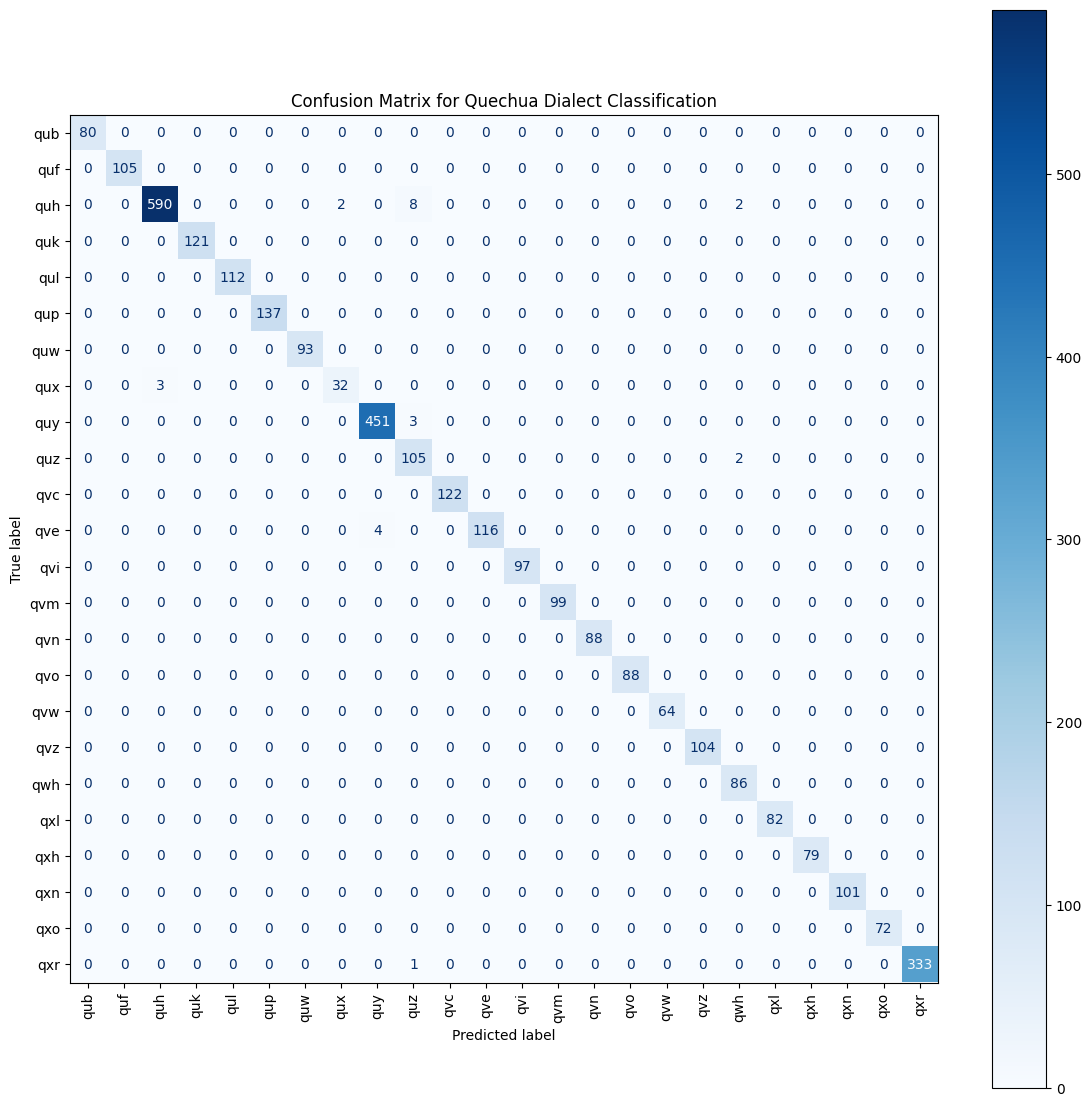

In [18]:
# Extract dialect names from the directory paths
dialect_labels = list(directory_paths.keys())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Create a confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dialect_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(14, 14))  # Adjust size as necessary for readability
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
ax.set_title('Confusion Matrix for Quechua Dialect Classification')
plt.show()

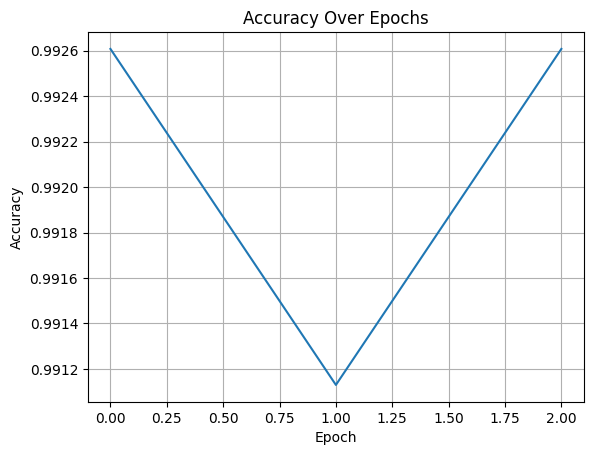

In [19]:
plt.plot(epoch_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

In [20]:
def get_predictions(model, dataloader):
    model.eval()  
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch['input_ids'].to(model.device),
                      'attention_mask': batch['attention_mask'].to(model.device)}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    return predictions, true_labels

In [21]:
from sklearn.metrics import classification_report

# Assuming you have a DataLoader for your validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)  # Adjust batch size as needed

# Get predictions
predictions, true_labels = get_predictions(model, val_dataloader)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=[label for label in directory_paths.keys()])
print("Classification Report:\n", report)

/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_93986/64439305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_93986/64439305.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)


Classification Report:
               precision    recall  f1-score   support

         qub       1.00      1.00      1.00        80
         quf       1.00      1.00      1.00       105
         quh       0.99      0.98      0.99       602
         quk       1.00      1.00      1.00       121
         qul       1.00      1.00      1.00       112
         qup       1.00      1.00      1.00       137
         quw       1.00      1.00      1.00        93
         qux       0.94      0.91      0.93        35
         quy       0.99      0.99      0.99       454
         quz       0.90      0.98      0.94       107
         qvc       1.00      1.00      1.00       122
         qve       1.00      0.97      0.98       120
         qvi       1.00      1.00      1.00        97
         qvm       1.00      1.00      1.00        99
         qvn       1.00      1.00      1.00        88
         qvo       1.00      1.00      1.00        88
         qvw       1.00      1.00      1.00        64
   

In [22]:
# # 5-fold cross validation

# def train_fold(train_idx, val_idx, model, tokenizer, compute_metrics, fold_number):
#     # Creating subsets for training and validation
#     train_subset = torch.utils.data.Subset(dataset, train_idx)
#     val_subset = torch.utils.data.Subset(dataset, val_idx)
    
#     # Convert to Hugging Face format datasets
#     train_dataset = Dataset.from_dict({k: train_subset[k] for k in ['input_ids', 'attention_mask', 'labels']})
#     val_dataset = Dataset.from_dict({k: val_subset[k] for k in ['input_ids', 'attention_mask', 'labels']})
    
#     # Define Trainer
#     training_args.output_dir = f'./results_fold_{fold_number}'  # Change output dir for each fold
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         compute_metrics=compute_metrics,
#         tokenizer=tokenizer
#     )
    
#     # Train the model
#     trainer.train()
#     return trainer.evaluate()

# # Store results from each fold
# results = []

# for fold_number, (train_idx, val_idx) in enumerate(kfold.split(dataset_list)):
#     print(f"Training fold {fold_number+1}/{kfold.n_splits}")
#     result = train_fold(train_idx, val_idx, model, tokenizer, compute_metrics, fold_number)
#     results.append(result)

# # Calculate and print average results across folds
# average_accuracy = np.mean([result['eval_accuracy'] for result in results])
# print(f"Average Cross-Validation Accuracy: {average_accuracy}")
